# Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from astropy.io import fits
import pandas as pd
import os

# Functions

In [65]:
#Reading data files

def locate(arr,x): #return arr[i] just larger than x
    i = 0
    while arr[i] < x:
        i += 1
    return i
    
def readSpec(csvFile):
    #csvFile: objName, expt_ch1, expt_ch2, expt_ch3, expt_ch4, longitude, latitude, ...
    specFile = pd.read_csv(csvFile)
    dataInfo = np.array(specFile)
    fileNo = np.ma.size(dataInfo,axis=0)
    exptArr = np.zeros((fileNo,4))
    longArr = np.zeros(fileNo)
    latArr = np.zeros(fileNo)
    for i in range(fileNo):
        exptArr[i,0] = dataInfo[i,1]  #s
        exptArr[i,1] = dataInfo[i,2]  #s
        exptArr[i,2] = dataInfo[i,3]  #s
        exptArr[i,3] = dataInfo[i,4]  #s
        longArr[i] = dataInfo[i,5]  #rad
        latArr[i] = dataInfo[i,6]  #rad
    return exptArr, longArr, latArr
    
def readFits(DirName, plotSpec=True):

    #Read .fits:
    hdul_ch1 = fits.open(DirName+'/x1d_ch1.fits')
    hdul_ch2 = fits.open(DirName+'/x1d_ch2.fits')
    hdul_ch3 = fits.open(DirName+'/x1d_ch3.fits')
    hdul_ch4 = fits.open(DirName+'/x1d_ch4.fits')

    #Physical quantities:
    wvlName = 'WAVELENGTH'
    fluxName = 'BACKGROUND'
    errorName = 'BKGD_ERROR'
    wvl_ch1 = hdul_ch1[1].data[wvlName]
    flux_ch1 = hdul_ch1[1].data[fluxName]
    bkgdErr_ch1 = hdul_ch1[1].data[errorName]
    wvl_ch2 = hdul_ch2[1].data[wvlName]
    flux_ch2 = hdul_ch2[1].data[fluxName]
    bkgdErr_ch2 = hdul_ch2[1].data[errorName]
    wvl_ch3 = hdul_ch3[1].data[wvlName]
    flux_ch3 = hdul_ch3[1].data[fluxName]
    bkgdErr_ch3 = hdul_ch3[1].data[errorName]
    wvl_ch4 = hdul_ch4[1].data[wvlName]
    flux_ch4 = hdul_ch4[1].data[fluxName]
    bkgdErr_ch4 = hdul_ch4[1].data[errorName]
    data_ch1 = np.array([wvl_ch1,flux_ch1,bkgdErr_ch1])
    data_ch2 = np.array([wvl_ch2,flux_ch2,bkgdErr_ch2])
    data_ch3 = np.array([wvl_ch3,flux_ch3,bkgdErr_ch3])
    data_ch4 = np.array([wvl_ch4,flux_ch4,bkgdErr_ch4])

    #Preview spectrum:
    if (plotSpec==True):
        #Basic info:
        print("Channel 1:")
        print("Wavelength range:", (wvl_ch1[0],wvl_ch1[-1]))
        print("Array shape:", wvl_ch1.shape)
        print("Bin size (dlmd):", wvl_ch1[1]-wvl_ch1[0])
        print("Channel 2:")
        print("Wavelength range:", (wvl_ch2[0],wvl_ch2[-1]))
        print("Array shape:", wvl_ch2.shape)
        print("Bin size (dlmd):", wvl_ch2[1]-wvl_ch2[0])
        print("Channel 3:")
        print("Wavelength range:", (wvl_ch3[0],wvl_ch3[-1]))
        print("Array shape:", wvl_ch3.shape)
        print("Bin size (dlmd):", wvl_ch3[1]-wvl_ch3[0])
        print("Channel 4:")
        print("Wavelength range:", (wvl_ch4[0],wvl_ch4[-1]))
        print("Array shape:", wvl_ch4.shape)
        print("Bin size (dlmd):", wvl_ch4[1]-wvl_ch4[0])
        
        plt.figure(figsize=(9,3))
        plt.step(wvl_ch1,flux_ch1)
        plt.step(wvl_ch2,flux_ch2)
        plt.step(wvl_ch3,flux_ch3)
        plt.step(wvl_ch4,flux_ch4)
        plt.yscale('log')
        #plt.xscale('log')
        plt.ylim(5,5000)
        plt.xlabel("Wavelength ($\\mu$m)")
        plt.ylabel("$\\Phi$ (MJy/sr)")
        plt.title("Spectrum preview")

    return data_ch1, data_ch2, data_ch3, data_ch4

def readFitsDir(Dir):
    visFile = [file for file in os.listdir(Dir) if not file.startswith('.')]
    fileNo = len(visFile)
    Ch1Arr, Ch2Arr, Ch3Arr, Ch4Arr = np.array([[],[],[],[]])
    for fileName in visFile:
        data_ch1, data_ch2, data_ch3, data_ch4 = readFits(Dir+'/'+fileName,plotSpec=False)
        print(data_ch1)
        if (len(Ch1Arr) == 0):
            Ch1Arr, Ch2Arr, Ch3Arr, Ch4Arr = (data_ch1,data_ch2,data_ch3,data_ch4)
        else:
            Ch1Arr = np.stack([Ch1Arr, data_ch1])
            Ch2Arr = np.stack([Ch2Arr, data_ch2])
            Ch3Arr = np.stack([Ch3Arr, data_ch3])
            Ch4Arr = np.stack([Ch4Arr, data_ch4])
    return Ch1Arr, Ch2Arr, Ch3Arr, Ch4Arr
        
def stackSpectra(Ch1Arr,Ch2Arr,Ch3Arr,Ch4Arr,exptArr,interp=False):
    
    fileNo = np.ma.size(Ch1Arr,axis=0)
    binNo1 = np.ma.size(Ch1Arr,axis=2)
    binNo2 = np.ma.size(Ch2Arr,axis=2)
    binNo3 = np.ma.size(Ch3Arr,axis=2)
    binNo4 = np.ma.size(Ch4Arr,axis=2)
    exptTotal = np.sum(exptArr,axis=0)
    n_total_ch1 = np.zeros(binNo1)
    n_total_ch2 = np.zeros(binNo2)
    n_total_ch3 = np.zeros(binNo3)
    n_total_ch4 = np.zeros(binNo4)
    dn_total_ch1 = np.zeros(binNo1)
    dn_total_ch2 = np.zeros(binNo2)
    dn_total_ch3 = np.zeros(binNo3)
    dn_total_ch4 = np.zeros(binNo4)
    
    
    for i in range(fileNo):
        if (interp==True):
            #Interp flux at new wavelengths
            Ch1Arr[i,1,:] = np.interp(Ch1Arr[0,0,:],Ch1Arr[i,0,:],Ch1Arr[i,1,:])
            Ch2Arr[i,1,:] = np.interp(Ch2Arr[0,0,:],Ch2Arr[i,0,:],Ch2Arr[i,1,:])
            Ch3Arr[i,1,:] = np.interp(Ch3Arr[0,0,:],Ch3Arr[i,0,:],Ch3Arr[i,1,:])
            Ch4Arr[i,1,:] = np.interp(Ch4Arr[0,0,:],Ch4Arr[i,0,:],Ch4Arr[i,1,:])
        n_total_ch1 += Ch1Arr[i,1,:]*exptArr[i,0]
        n_total_ch2 += Ch2Arr[i,1,:]*exptArr[i,1]
        n_total_ch3 += Ch3Arr[i,1,:]*exptArr[i,2]
        n_total_ch4 += Ch4Arr[i,1,:]*exptArr[i,3]
        #Propagation of error
        dn_total_ch1 += Ch1Arr[i,2,:]*exptArr[i,0]*Ch1Arr[i,2,:]*exptArr[i,0]
        dn_total_ch2 += Ch2Arr[i,2,:]*exptArr[i,1]*Ch2Arr[i,2,:]*exptArr[i,1]
        dn_total_ch3 += Ch3Arr[i,2,:]*exptArr[i,2]*Ch3Arr[i,2,:]*exptArr[i,1]
        dn_total_ch4 += Ch4Arr[i,2,:]*exptArr[i,3]*Ch4Arr[i,2,:]*exptArr[i,1]
        
    flux_ch1 = n_total_ch1/exptTotal[0]
    flux_ch2 = n_total_ch2/exptTotal[1]
    flux_ch3 = n_total_ch3/exptTotal[2]
    flux_ch4 = n_total_ch4/exptTotal[3]
    err_ch1 = np.sqrt(dn_total_ch1)/exptTotal[0]
    err_ch2 = np.sqrt(dn_total_ch2)/exptTotal[1]
    err_ch3 = np.sqrt(dn_total_ch3)/exptTotal[2]
    err_ch4 = np.sqrt(dn_total_ch4)/exptTotal[3]

    stkdata_ch1 = np.array([Ch1Arr[0,0,:],flux_ch1,err_ch1])
    stkdata_ch2 = np.array([Ch2Arr[0,0,:],flux_ch2,err_ch2])
    stkdata_ch3 = np.array([Ch3Arr[0,0,:],flux_ch3,err_ch3])
    stkdata_ch4 = np.array([Ch4Arr[0,0,:],flux_ch4,err_ch4])
    return stkdata_ch1, stkdata_ch2, stkdata_ch3, stkdata_ch4

def previewSpec(stkdata_ch1, stkdata_ch2, stkdata_ch3, stkdata_ch4):
    wvl_ch1, flux_ch1, err_ch1 = stkdata_ch1
    wvl_ch2, flux_ch2, err_ch2 = stkdata_ch2
    wvl_ch3, flux_ch3, err_ch3 = stkdata_ch3
    wvl_ch4, flux_ch4, err_ch4 = stkdata_ch4
    p1 = locate(wvl_ch1,5.350) 
    p2 = locate(wvl_ch1,5.525)
    wvlCut = wvl_ch1[p1:p2]
    fluxCut = flux_ch1[p1:p2]
    errorCut = err_ch1[p1:p2]
    
    plt.figure(figsize=(9,6))
    plt.subplot(211)  
    plt.step(wvl_ch1,flux_ch1)
    plt.step(wvl_ch2,flux_ch2)
    plt.step(wvl_ch3,flux_ch3)
    plt.step(wvl_ch4,flux_ch4)
    plt.xlabel("Wavelength ($\\mu$m)")
    plt.ylabel("$\\Phi$ (Jy/sr)")
    plt.xscale('log')
    plt.yscale('log')
    #plt.ylim(0, 0.3)
    
    plt.subplot(212)
    plt.step(wvlCut,fluxCut,'black')
    plt.fill_between(wvlCut,fluxCut+errorCut,fluxCut-errorCut,step="pre",color='silver')
    #plt.ylim(0.08,0.14)
    plt.xlabel("Wavelength ($\\mu$m)")
    plt.ylabel("$\\Phi$ (Jy/sr)")
    plt.tight_layout(pad=0.9)

# Read fits

In [66]:
exptArr, longArr, latArr = readSpec('MRS_objects.csv')
print(exptArr)

[[12088.08 12088.08 12088.08 12088.08]
 [12088.08 12088.08 12088.08 12088.08]]


In [67]:
Ch1Arr, Ch2Arr, Ch3Arr, Ch4Arr = readFitsDir("MRS_data")
print(Ch1Arr[0,2,:])

[[ 4.9004001   4.9012001   4.9020001  ...  7.64840003  7.64920003
   7.65000003]
 [76.90874601 71.16004578 69.86743375 ... 15.71364323 11.32199798
  12.56753236]
 [ 0.15262374  0.14962515  0.14946365 ...  0.13341612  0.13444788
   0.12525835]]
[[  4.9004001    4.9012001    4.9020001  ...   7.64840003   7.64920003
    7.65000003]
 [114.57780032 108.04073994 106.35691506 ...  64.53222545  58.54683743
   62.54118109]
 [  0.19913519   0.19549945   0.19648375 ...   0.15704461   0.1578564
    0.14831113]]
[0.15262374 0.14962515 0.14946365 ... 0.13341612 0.13444788 0.12525835]


## Samples

In [44]:
#Sample file
fitsFile_ch1 = "MRS_data/MAST_2024-07-04T0025/JWST/jw02260-o005_t005_miri_ch1-shortmediumlong/jw02260-o005_t005_miri_ch1-shortmediumlong_x1d.fits"
sub1_ch1 = fits.open(fitsFile_ch1)
fitsFile_ch2 = "MRS_data/MAST_2024-07-04T0025/JWST/jw02260-o005_t005_miri_ch2-shortmediumlong/jw02260-o005_t005_miri_ch2-shortmediumlong_x1d.fits"
sub1_ch2 = fits.open(fitsFile_ch2)
fitsFile_ch3 = "MRS_data/MAST_2024-07-04T0025/JWST/jw02260-o005_t005_miri_ch3-shortmediumlong/jw02260-o005_t005_miri_ch3-shortmediumlong_x1d.fits"
sub1_ch3 = fits.open(fitsFile_ch3)
fitsFile_ch4 = "MRS_data/MAST_2024-07-04T0025/JWST/jw02260-o005_t005_miri_ch4-shortmediumlong/jw02260-o005_t005_miri_ch4-shortmediumlong_x1d.fits"
sub1_ch4 = fits.open(fitsFile_ch4)
print(sub1_ch1.info())
print('###############################################################################')
print(sub1_ch1[1].header)
#0th HDU: Info of data (including calibration)
#1st HDU: Data
#2nd HDU: Additional info of data

Filename: MRS_data/MAST_2024-07-04T0025/JWST/jw02260-o005_t005_miri_ch1-shortmediumlong/jw02260-o005_t005_miri_ch1-shortmediumlong_x1d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     373   ()      
  1  EXTRACT1D     1 BinTableHDU     69   3438R x 18C   [D, D, D, D, D, D, D, D, D, D, D, J, D, D, D, D, D, D]   
  2  ASDF          1 BinTableHDU     11   1R x 1C   [67910B]   
None
###############################################################################
XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                  140 / length of dimension 1                          NAXIS2  =                 3438 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOU

Channel 1:
Wavelength range: (4.900400095357327, 7.650000025896588)
Array shape: (3438,)
Bin size (dlmd): 0.0007999999797903001
Channel 2:
Wavelength range: (7.5106502288836055, 11.700550240289886)
Array shape: (3224,)
Bin size (dlmd): 0.0013000000035390258
Channel 3:
Wavelength range: (11.551250190706924, 17.978750047041103)
Array shape: (2572,)
Bin size (dlmd): 0.0024999999441206455
Channel 4:
Wavelength range: (17.70300076296553, 28.70100085856393)
Array shape: (1834,)
Bin size (dlmd): 0.006000000052154064


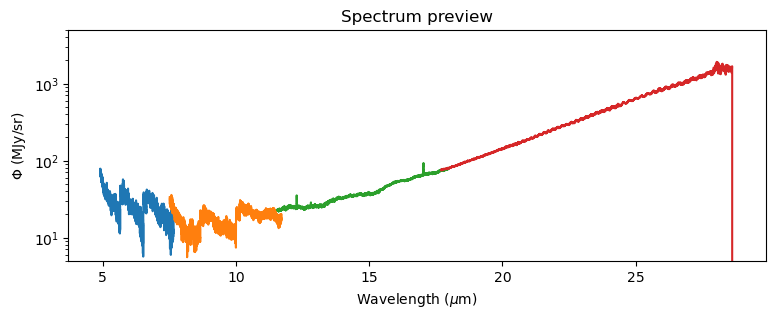

In [45]:
data_ch1_sb1, data_ch2_sb1, data_ch3_sb1, data_ch4_sb1 = readFits('MRS_data/MAST_2024-07-04T0025')

Channel 1:
Wavelength range: (4.900400095357327, 7.650000025896588)
Array shape: (3438,)
Bin size (dlmd): 0.0007999999797903001
Channel 2:
Wavelength range: (7.5106502288836055, 11.700550240289886)
Array shape: (3224,)
Bin size (dlmd): 0.0013000000035390258
Channel 3:
Wavelength range: (11.551250190706924, 17.978750047041103)
Array shape: (2572,)
Bin size (dlmd): 0.0024999999441206455
Channel 4:
Wavelength range: (17.70300076296553, 28.70100085856393)
Array shape: (1834,)
Bin size (dlmd): 0.006000000052154064


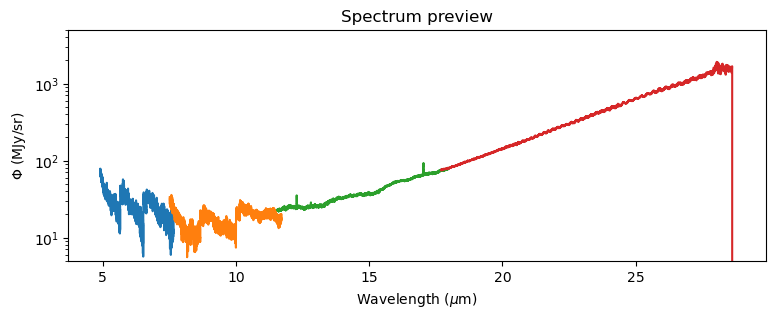

In [46]:
data_ch1_sb2, data_ch2_sb2, data_ch3_sb2, data_ch4_sb2 = readFits('MRS_data/MAST_2024-07-04T0025')

* Creat a for loop to read all the files in a dir and then store all the data into Ch1Arr, Ch2Arr, Ch3Arr, Ch4Arr.

# Stack spectra

In [68]:
stkdata_ch1, stkdata_ch2, stkdata_ch3, stkdata_ch4 = stackSpectra(Ch1Arr,Ch2Arr,Ch3Arr,Ch4Arr,exptArr)

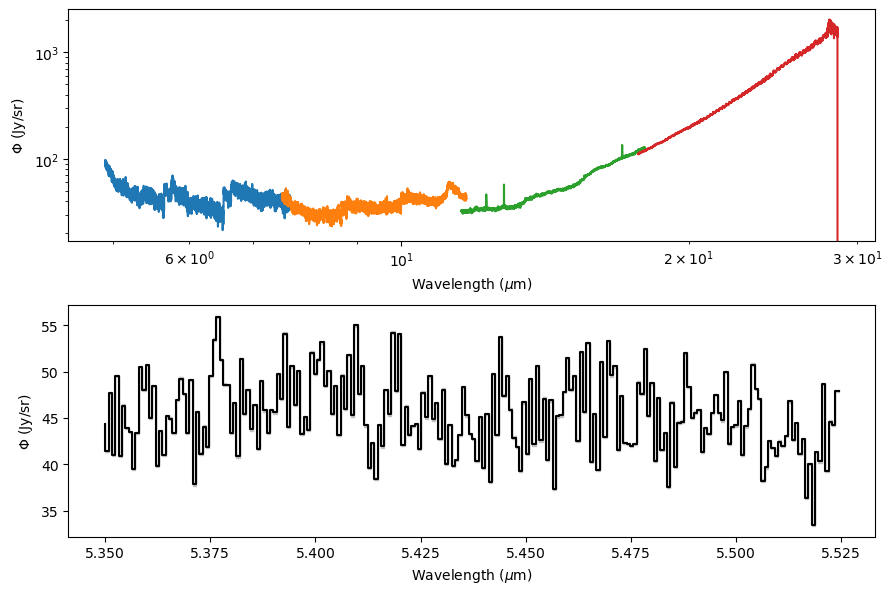

In [69]:
#Preview:
previewSpec(stkdata_ch1, stkdata_ch2, stkdata_ch3, stkdata_ch4)

In [70]:
#Output array files:
np.savez('stkData.npz',ch1=stkdata_ch1, ch2=stkdata_ch2, ch3=stkdata_ch3, ch4=stkdata_ch4)